In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import scipy.io as sio
from keras.layers import Conv2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks  import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, auc
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks  import EarlyStopping
from sklearn.metrics import confusion_matrix
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
#dataPath = '../data/butter_feature_tensor_with_labels.mat'
#dataPath = '../data/csp_features_full_with_full_labels.csv'
dataPath = '../data/spectral_feat_tensor_full_with_full_labels_images.mat'
savePath = '../Results/Spectral/'

experiment = 'PDNC_spectral_Full'

filename = savePath+'CNN_2D_results_'+experiment+'.mat'
plot_title = 'PD vs NC Classification for Spectral Features - Full'

nb_filters = [16, 32, 32, 64, 128]
kernel_size = 3
pool_size = 2
stride_size = 2
padding = 'same'
weight_decay = 0.000001
dense_layer_neuron_num = 128
epochs = 30
momentum =0.8

matContent = sio.loadmat(dataPath)
features = matContent['full_feat_img']
labels = np.squeeze(matContent['full_pdnc_labels'])
labels[labels < 0] = 0
features = np.swapaxes(features,1,3)
features = np.swapaxes(features,1,2)
#labels[labels == 6] = 0
#labels = labels.astype(int)

#df = pd.read_csv(dataPath, header = None)
#features = df.iloc[1:,:-2].to_numpy()
#labels = df.iloc[1:,-1].to_numpy() # last but one column for PD vs NC

#dict_hvlv = {1:0, 2:1, 3:0, 4:0, 5:1, 6:0} #HVLV labels mapping dictionary
#labels = labels.map(dict_hvlv).to_numpy()
#labels[labels == 1] = 0
#labels[labels == 2] = 1
#labels[labels == 3] = 1
#labels[labels == 4] = 1
#labels[labels == 5] = 1
#labels[labels == 6] = 1
#labels[labels < 0]=0
labels[labels == 6]=0

# randomise the sample sequence
rand_order = np.arange(features.shape[0])
np.random.shuffle(rand_order)
features = features[rand_order,]
labels = np.squeeze(labels[rand_order,])
class_num = np.size(np.unique(labels))
labels_categorical = np_utils.to_categorical(labels, class_num)
del matContent

In [3]:
labels_categorical

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [4]:
class_num

2

In [5]:
features.shape

(14800, 32, 32, 3)

In [6]:
np.unique(labels)

array([0, 1])

In [7]:
def create_model(init_mode, activation, dropout_rate, optimizer, learn_rate):
#def create_model(activation):
  model = Sequential()
  model.add(Conv2D(filters=nb_filters[0], kernel_size=kernel_size, padding=padding,
                   activation=activation, input_shape=(features.shape[1], features.shape[2], features.shape[3]), trainable=True))
  model.add(AveragePooling2D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv2D(filters=nb_filters[1], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling2D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv2D(filters=nb_filters[2], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling2D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  #model.add(Conv1D(filters=nb_filters[3], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  #model.add(Conv1D(filters=nb_filters[4], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  model.add(Flatten())
  model.add(BatchNormalization(epsilon=0.001))
  model.add(Dense(dense_layer_neuron_num, kernel_initializer=init_mode, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(class_num))
  model.add(Activation('softmax'))
  #model.summary()
  #model.load_weights('Gender_notClean_HIweights.hdf5')
  #earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
  if optimizer == 'SGD':
    opt = SGD(learning_rate=learn_rate / 10 ** epochs, momentum = momentum, decay = weight_decay, nesterov = True)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'Adam':
    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'RMSprop':
    opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model


In [8]:
cnn_model = KerasClassifier(build_fn=create_model, verbose=0)

#batch_size = [16,32]
#epochs = [5,10,15]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'he_normal', 'he_uniform']
#activation = ['softmax', 'softsign', 'relu', 'tanh', 'sigmoid', 'linear']
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#neurons = [1, 5, 10, 15, 20, 25, 30]

learn_rate = [0.001, 0.01, 0.1]
optimizer = ['SGD', 'Adam','RMSprop']
#momentum = [0.8,0.9]
init_mode = ['he_normal','he_uniform']
activation = ['relu','tanh']
dropout_rate = [0.3,0.4,0.5]
foldNum = 10

p_grid = dict(init_mode=init_mode, dropout_rate=dropout_rate, activation=activation,
              optimizer=optimizer, learn_rate=learn_rate)
              #, momentum=momentum)
grid = GridSearchCV(estimator=cnn_model, param_grid=p_grid,
                    cv=foldNum, verbose=0)
# Standerdize
#feat_shape = features.shape
#features = np.reshape(features, (feat_shape[0], feat_shape[1]*feat_shape[2]))
#scaler = StandardScaler()
#scaler.fit(features)
#scaleFeatures = scaler.transform(features)
#scaleFeatures = np.reshape(scaleFeatures, (features.shape[0], 6, -1))

print('Performing Gridsearch')
grid_result = grid.fit(features,labels_categorical)
best_params = grid_result.best_params_
print('Best parameters:', best_params)
estimator = create_model(init_mode=best_params.get('init_mode'), 
                         learn_rate=best_params.get('learn_rate'), 
                         optimizer=best_params.get('optimizer'), 
                         #momentum=best_params.get('momentum'), 
                         activation=best_params.get('activation'), 
                         dropout_rate=best_params.get('dropout_rate'))

Performing Gridsearch
Best parameters: {'activation': 'relu', 'dropout_rate': 0.3, 'init_mode': 'he_uniform', 'learn_rate': 0.1, 'optimizer': 'Adam'}


Model: "sequential_1081"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3243 (Conv2D)         (None, 32, 32, 16)        448       
_________________________________________________________________
average_pooling2d_3243 (Aver (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3244 (Conv2D)         (None, 16, 16, 32)        4640      
_________________________________________________________________
average_pooling2d_3244 (Aver (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3245 (Conv2D)         (None, 8, 8, 32)          9248      
_________________________________________________________________
average_pooling2d_3245 (Aver (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1081 (Flatten)       (None, 512)           

Epoch 5/30
375/375 - 1s - loss: 0.0317 - accuracy: 0.9892 - val_loss: 0.2456 - val_accuracy: 0.9730
Epoch 6/30
375/375 - 1s - loss: 0.0345 - accuracy: 0.9874 - val_loss: 0.2087 - val_accuracy: 0.9730
Epoch 7/30
375/375 - 1s - loss: 0.0404 - accuracy: 0.9852 - val_loss: 0.1414 - val_accuracy: 0.9812
Epoch 8/30
375/375 - 1s - loss: 0.0376 - accuracy: 0.9869 - val_loss: 0.1814 - val_accuracy: 0.9760
Epoch 9/30
375/375 - 1s - loss: 0.0299 - accuracy: 0.9891 - val_loss: 0.1867 - val_accuracy: 0.9775
Epoch 10/30
375/375 - 1s - loss: 0.0287 - accuracy: 0.9896 - val_loss: 0.1560 - val_accuracy: 0.9820
Epoch 11/30
375/375 - 1s - loss: 0.0269 - accuracy: 0.9907 - val_loss: 0.0848 - val_accuracy: 0.9752
Epoch 12/30
375/375 - 1s - loss: 0.0253 - accuracy: 0.9902 - val_loss: 0.0739 - val_accuracy: 0.9820
Epoch 13/30
375/375 - 1s - loss: 0.0304 - accuracy: 0.9897 - val_loss: 0.1456 - val_accuracy: 0.9692
Epoch 14/30
375/375 - 1s - loss: 0.0231 - accuracy: 0.9914 - val_loss: 0.2229 - val_accuracy: 0.

Epoch 1/30
375/375 - 1s - loss: 0.0225 - accuracy: 0.9942 - val_loss: 0.1235 - val_accuracy: 0.9722
Epoch 2/30
375/375 - 1s - loss: 0.0150 - accuracy: 0.9942 - val_loss: 0.2144 - val_accuracy: 0.9775
Epoch 3/30
375/375 - 1s - loss: 0.0211 - accuracy: 0.9918 - val_loss: 0.0917 - val_accuracy: 0.9767
Epoch 4/30
375/375 - 1s - loss: 0.0146 - accuracy: 0.9957 - val_loss: 0.0756 - val_accuracy: 0.9805
Epoch 5/30
375/375 - 1s - loss: 0.0213 - accuracy: 0.9926 - val_loss: 0.1439 - val_accuracy: 0.9745
Epoch 6/30
375/375 - 1s - loss: 0.0237 - accuracy: 0.9922 - val_loss: 0.0767 - val_accuracy: 0.9775
Epoch 7/30
375/375 - 1s - loss: 0.0218 - accuracy: 0.9929 - val_loss: 0.0767 - val_accuracy: 0.9775
Epoch 8/30
375/375 - 1s - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0877 - val_accuracy: 0.9782
Epoch 9/30
375/375 - 1s - loss: 0.0200 - accuracy: 0.9930 - val_loss: 0.0658 - val_accuracy: 0.9775
Epoch 10/30
375/375 - 1s - loss: 0.0136 - accuracy: 0.9950 - val_loss: 0.0741 - val_accuracy: 0.9745

Epoch 1/30
375/375 - 1s - loss: 0.0192 - accuracy: 0.9945 - val_loss: 0.1419 - val_accuracy: 0.9760
Epoch 2/30
375/375 - 1s - loss: 0.0101 - accuracy: 0.9965 - val_loss: 0.1358 - val_accuracy: 0.9835
Epoch 3/30
375/375 - 1s - loss: 0.0089 - accuracy: 0.9963 - val_loss: 0.1279 - val_accuracy: 0.9812
Epoch 4/30
375/375 - 1s - loss: 0.0132 - accuracy: 0.9956 - val_loss: 0.1290 - val_accuracy: 0.9812
Epoch 5/30
375/375 - 1s - loss: 0.0114 - accuracy: 0.9958 - val_loss: 0.1335 - val_accuracy: 0.9775
Epoch 6/30
375/375 - 1s - loss: 0.0124 - accuracy: 0.9961 - val_loss: 0.2061 - val_accuracy: 0.9737
Epoch 7/30
375/375 - 1s - loss: 0.0141 - accuracy: 0.9956 - val_loss: 0.1472 - val_accuracy: 0.9722
Epoch 8/30
375/375 - 1s - loss: 0.0124 - accuracy: 0.9957 - val_loss: 0.1073 - val_accuracy: 0.9805
Epoch 9/30
375/375 - 1s - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.1010 - val_accuracy: 0.9850
Epoch 10/30
375/375 - 1s - loss: 0.0079 - accuracy: 0.9978 - val_loss: 0.1084 - val_accuracy: 0.9805

Epoch 1/30
375/375 - 1s - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.1294 - val_accuracy: 0.9857
Epoch 2/30
375/375 - 1s - loss: 0.0146 - accuracy: 0.9951 - val_loss: 0.1670 - val_accuracy: 0.9820
Epoch 3/30
375/375 - 1s - loss: 0.0112 - accuracy: 0.9966 - val_loss: 0.1455 - val_accuracy: 0.9835
Epoch 4/30
375/375 - 1s - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.1359 - val_accuracy: 0.9820
Epoch 5/30
375/375 - 1s - loss: 0.0069 - accuracy: 0.9973 - val_loss: 0.1066 - val_accuracy: 0.9797
Epoch 6/30
375/375 - 1s - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0.1397 - val_accuracy: 0.9835
Epoch 7/30
375/375 - 1s - loss: 0.0118 - accuracy: 0.9967 - val_loss: 0.1531 - val_accuracy: 0.9850
Epoch 8/30
375/375 - 1s - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.2221 - val_accuracy: 0.9850
Epoch 9/30
375/375 - 1s - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.2816 - val_accuracy: 0.9865
Epoch 10/30
375/375 - 1s - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.1554 - val_accuracy: 0.9827

Epoch 1/30
375/375 - 1s - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.1967 - val_accuracy: 0.9827
Epoch 2/30
375/375 - 1s - loss: 0.0094 - accuracy: 0.9967 - val_loss: 0.1316 - val_accuracy: 0.9835
Epoch 3/30
375/375 - 1s - loss: 0.0078 - accuracy: 0.9978 - val_loss: 0.1129 - val_accuracy: 0.9850
Epoch 4/30
375/375 - 1s - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.1439 - val_accuracy: 0.9797
Epoch 5/30
375/375 - 1s - loss: 0.0116 - accuracy: 0.9960 - val_loss: 0.1512 - val_accuracy: 0.9745
Epoch 6/30
375/375 - 1s - loss: 0.0135 - accuracy: 0.9962 - val_loss: 0.1261 - val_accuracy: 0.9775
Epoch 7/30
375/375 - 1s - loss: 0.0056 - accuracy: 0.9977 - val_loss: 0.1916 - val_accuracy: 0.9812
Epoch 8/30
375/375 - 1s - loss: 0.0114 - accuracy: 0.9962 - val_loss: 0.2066 - val_accuracy: 0.9752
Epoch 9/30
375/375 - 1s - loss: 0.0081 - accuracy: 0.9981 - val_loss: 0.1848 - val_accuracy: 0.9857
Epoch 10/30
375/375 - 1s - loss: 0.0069 - accuracy: 0.9976 - val_loss: 0.3010 - val_accuracy: 0.9857

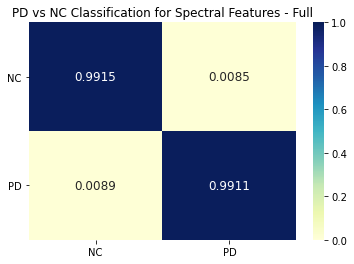

Mean and std of F1 MACRO is 0.9913 +- 0.0068
Mean and std of F1 WEIGHTED is 0.9913 +- 0.0068
Mean and std of accuracy is 0.9913 +- 0.0068


In [9]:
conf_mat = np.zeros((2,2))
f = 0
f1_MacroNet = np.zeros([foldNum,]) 
f1_weightedNet = np.zeros([foldNum,])
precisionNet = np.zeros([foldNum,])
recallNet = np.zeros([foldNum,])
accNet = np.zeros([foldNum,])

#channels = features.shape[2] # number of channels 14
kfold = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)

for train, test in kfold.split(features, labels):
  trainingFeatures = features[train,:,:, :]
  testFeatures = features[test,:,:, :]
  train_shape = trainingFeatures.shape
  test_shape = testFeatures.shape
  
  estimator.summary()
  estimator.fit(trainingFeatures, labels_categorical[train,:], batch_size=32, 
                epochs=epochs, verbose=2, validation_split=0.1)

  predicted_labelsNet = estimator.predict_classes(testFeatures, verbose=0)
  predicted_probsNet = estimator.predict_proba(testFeatures,batch_size=1,verbose=0)
  cm = confusion_matrix(labels[test,], predicted_labelsNet, labels=[0,1])
  conf_mat = conf_mat+cm

  precisionNet[f] = precision_score(labels[test,], predicted_labelsNet, average='macro')
  recallNet[f] = recall_score(labels[test,], predicted_labelsNet, average='macro')
  f1_MacroNet[f] = f1_score(labels[test,], predicted_labelsNet, average='macro')
  f1_weightedNet[f] = f1_score(labels[test,], predicted_labelsNet, average='weighted')
  accNet[f] = accuracy_score(labels[test,], predicted_labelsNet)
  print(experiment + '_CNN: Fold %d : f1_macroscore: %.4f' % (f + 1, f1_MacroNet[f]))
  print(experiment + '_CNN: Fold %d : f1_weightedscore: %.4f' % (f + 1, f1_weightedNet[f]))
  print(experiment + '_CNN: Fold %d : acc: %.4f' % (f + 1, accNet[f]))
  f += 1

conf_mat /= conf_mat.sum(axis=1, keepdims = True)
ax = sns.heatmap(conf_mat, cmap='YlGnBu', annot = True, fmt='.4f', vmin=0, vmax=1, annot_kws = {'fontsize':12})
ax.set_yticklabels(['NC', 'PD'], rotation = 0) # for CSP and IIR
#ax.set_yticklabels(['PD', 'NC'], rotation = 0) # for spectral
#ax.set_yticklabels(['LA', 'HA'], rotation = 0)
#ax.set_yticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)
#ax.set_xticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)
#ax.set_xticklabels(['LA', 'HA'], rotation = 0)
ax.set_xticklabels(['NC', 'PD'], rotation = 0) # for CSP and IIR
#ax.set_xticklabels(['PD', 'NC'], rotation = 0) # for spectral

ax.set_title(plot_title)
ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

print('Mean and std of F1 MACRO is %.4f +- %.4f' % (np.mean(f1_MacroNet), np.std(f1_MacroNet)))
print('Mean and std of F1 WEIGHTED is %.4f +- %.4f' % (np.mean(f1_weightedNet), np.std(f1_weightedNet)))
print('Mean and std of accuracy is %.4f +- %.4f' % (np.mean(accNet), np.std(accNet)))

# Save results
sio.savemat(filename, {'precisionNet': precisionNet,'recallNet': recallNet, 'f1_MacroNet': f1_MacroNet,
                       'f1_weightedNet':f1_weightedNet,'accNet':accNet, 'conf_mat':conf_mat,
                      'best_params':best_params, 'experiment':experiment,'nb_filters':nb_filters,
                       'kernel_size':kernel_size, 'pool_size':pool_size, 'stride_size':stride_size,'padding':padding,
                       'weight_decay':weight_decay, 'dense_layer_neuron_num':dense_layer_neuron_num,'epochs':epochs})